# Learning diffusion with a neural partial differential equation

In [115]:
using LinearAlgebra

using DifferentialEquations
using DiffEqSensitivity
using Flux
using DiffEqFlux

using Flux: @epochs

using Plots
default(fmt = :png)

We want to solve the heat (or diffusion) equation

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}, \quad x \in \left[-\frac{1}{2}, \frac{1}{2}\right], \quad x\left(-\frac{1}{2}\right) = x\left(\frac{1}{2}\right)$$

Let's go with $N = 16$ grid points and $\kappa = 1$.

In [76]:
N = 16
L = 1
Δx = L / N
κ = 1

x = range(-L/2, L/2, length=N)

-0.5:0.06666666666666667:0.5

Discretizing the spatial derivative with a second-order centered finite-difference

$$\frac{\partial u_i}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2} \approx \kappa \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta x^2}$$

we get a system of $N$ coupled ODEs which can be described as

$$ \frac{\partial u}{\partial t} = Au $$

where $A$ is a matrix.

In [77]:
function diffusion!(∂u∂t, u, p, t)
    N, Δx, κ = p.N, p.Δx, p.κ
    @inbounds begin
        ∂u∂t[1] = κ * (u[N] -2u[1] + u[2]) / Δx
        for i in 2:N-1
            ∂u∂t[i] = κ * (u[i-1] -2u[i] + u[i+1]) / Δx
        end
        ∂u∂t[N] = κ * (u[N-1] -2u[N] + u[1]) / Δx
    end
    return 
end

diffusion! (generic function with 1 method)

Let's generate an initial condition

$$ u_0(x) = e^{-100x^2} $$

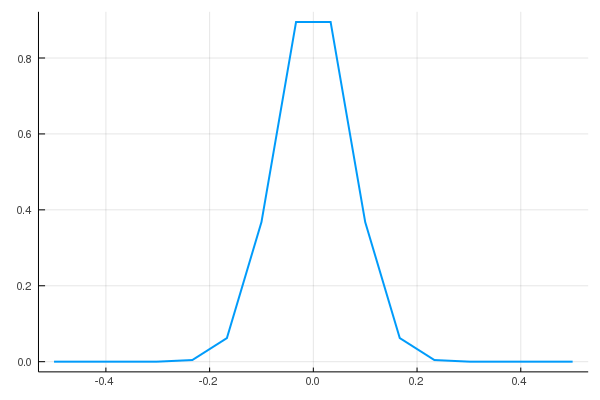

In [78]:
u₀ = @. exp(-100*x^2)

plot(x, u₀, linewidth=2, label="")

We'll pick 30 equally spaced times between $t = 0$ and $t = 0.1$ to save the state of the PDE.

In [79]:
tspan = (0.0, 0.1)
Nt_data = 30
Δt_data = (tspan[2] - tspan[1]) / Nt_data
t = range(tspan[1], tspan[2], length=Nt_data)

0.0:0.0034482758620689655:0.1

Set up and solve the PDE.

In [80]:
params = (N=N, Δx=Δx, κ=κ)
prob = ODEProblem(diffusion!, u₀, tspan, params)
sol = solve(prob, Tsit5(), saveat=t);

In [99]:
uₙ    = zeros(N, Nt_data-1)
uₙ₊₁  = zeros(N, Nt_data-1)

for i in 1:Nt_data-1
       uₙ[:, i] .=  sol.u[i]
     uₙ₊₁[:, i] .=  sol.u[i+1]
end

training_data = [(uₙ[:, i], uₙ₊₁[:, i]) for i in 1:Nt_data-1];

Let's plot the solution

┌ Info: Saved animation to 
│   fn = /home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusing_gaussian.gif
└ @ Plots /home/alir/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusing_gaussian.gif")
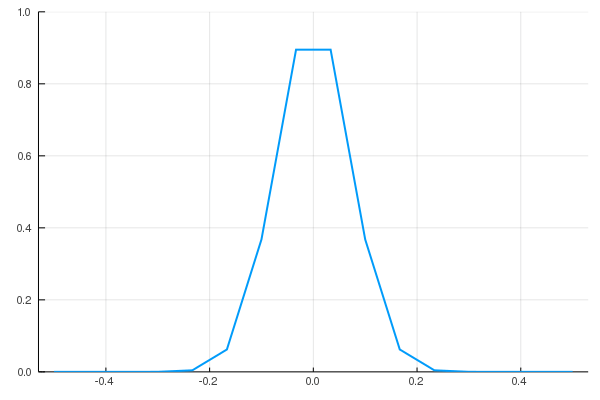

In [100]:
anim = @animate for n=1:Nt_data
    plot(x, sol.u[n], linewidth=2, ylim=(0, 1), label="", show=false)
end

gif(anim, "diffusing_gaussian.gif", fps=15)

Now let's create a two-layer neural network to see if we can learn diffusion

In [101]:
dudt_NN = Chain(Dense(N, 100, tanh),
                Dense(100, N))

Chain(Dense(16, 100, tanh), Dense(100, 16))

Set up a neural PDE that solves the system of ODEs described by

$$ \frac{\partial u}{\partial t} = \text{NN}(u) $$

In [104]:
tspan_npde = (0.0, Δt_data)
diffusion_npde = NeuralODE(dudt_NN, tspan_npde, Tsit5(), reltol=1e-4, saveat=[Δt_data]);

Define the loss/objective function to be

$$ \left| u(x, t) - u_{NN}(x, t) \right|^2 \approx \sum_{n=1}^{N_t} \sum_{i=1}^{N_x} \left| u_i^n - (u_{NN})_i^n \right|^2 $$

In [109]:
loss_function(uₙ, uₙ₊₁) = Flux.mse(uₙ₊₁, diffusion_npde(uₙ))

loss_function (generic function with 1 method)

Use the Adam optimization algorithm (adaptive moment estimation?). Seems to be recommended as a good default.

In [119]:
opt = ADAM(1e-2)
# opt = Descent()

ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}())

Define a callback function to observe training in progress and stop once loss is acceptable.

In [120]:
function cb()
    train_loss = sum([loss_function(training_data[i]...) for i in 1:Nt_data-1])
    println("train_loss = $train_loss")    
    return train_loss
end

cb();

train_loss = 0.0022281566734242766


Training!

In [121]:
@epochs 10 Flux.train!(loss_function, Flux.params(diffusion_npde), training_data, opt, cb=cb)

┌ Info: Epoch 1
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0026892034929551865
train_loss = 0.004337194429514797
train_loss = 0.007215034474700238
train_loss = 0.010111066250853097
train_loss = 0.011748838747038857
train_loss = 0.011778539063606855
train_loss = 0.01056861682474149
train_loss = 0.008688035155977136
train_loss = 0.006667499001461888
train_loss = 0.004895768814383962
train_loss = 0.003583459698732385
train_loss = 0.0027886433870562308
train_loss = 0.0024659048806391446
train_loss = 0.002515609361677734
train_loss = 0.0028224930397367136
train_loss = 0.003278607774096804
train_loss = 0.0037940063164712567
train_loss = 0.00430006097542718
train_loss = 0.004749415672135401
train_loss = 0.005114988005960147
train_loss = 0.0053873846093347895
train_loss = 0.0055701507251527185
train_loss = 0.005674347296412248
train_loss = 0.00571412953365144
train_loss = 0.005703963152389072
train_loss = 0.005657483633024361
train_loss = 0.00558757131471924
train_loss = 0.005506677756496276
train_loss = 0.0054266595097604954
train_loss

┌ Info: Epoch 2
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0033956408275770834
train_loss = 0.002934746276092334
train_loss = 0.0028287971153633236
train_loss = 0.003116952434266622
train_loss = 0.003756194658227768
train_loss = 0.0046056079454319335
train_loss = 0.005434873547337952
train_loss = 0.005987701535955543
train_loss = 0.0060875516241661225
train_loss = 0.005714914173152022
train_loss = 0.004997243465484863
train_loss = 0.0041363981590642265
train_loss = 0.0033329309812524933
train_loss = 0.002738799603039013
train_loss = 0.0024372092986338716
train_loss = 0.0024415546947414444
train_loss = 0.0027084727773278717
train_loss = 0.003159226085560017
train_loss = 0.0037027806009519797
train_loss = 0.0042553658801797525
train_loss = 0.004753351056222245
train_loss = 0.00515850782948883
train_loss = 0.005456771945507635
train_loss = 0.005652793311241021
train_loss = 0.005762662020922203
train_loss = 0.005806773285687016
train_loss = 0.005804256120816307
train_loss = 0.005208351899450377


┌ Info: Epoch 3
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0043074531842034304
train_loss = 0.0033439876519583576
train_loss = 0.002523249902678533
train_loss = 0.002003791979038467
train_loss = 0.001879705180396589
train_loss = 0.0021633541068332407
train_loss = 0.0027740026829461686
train_loss = 0.0035410851855357806
train_loss = 0.004239105380683332
train_loss = 0.004658233729912583
train_loss = 0.004680978256929194
train_loss = 0.004318093584431125
train_loss = 0.0036855676044738727
train_loss = 0.0029478432252806703
train_loss = 0.0022634981257284342
train_loss = 0.0017517288216123824
train_loss = 0.0014795651247719744
train_loss = 0.0014631164504001043
train_loss = 0.0016770085519893212
train_loss = 0.002067685266887096
train_loss = 0.002567383447082402
train_loss = 0.003106689565649504
train_loss = 0.003624527201117746
train_loss = 0.00407487481172866
train_loss = 0.0044297376188845855
train_loss = 0.0046784545193011146
train_loss = 0.004824203386115337
train_loss = 0.004879184712837808
train_loss = 0.004369329234689337
t

┌ Info: Epoch 4
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0019322776122229135
train_loss = 0.0014492826843504327
train_loss = 0.001296154425826722
train_loss = 0.0014677320674113476
train_loss = 0.00189557818197698
train_loss = 0.0024587804930224157
train_loss = 0.003004384799041727
train_loss = 0.003382020118542626
train_loss = 0.0034871090534651975
train_loss = 0.003294925228448218
train_loss = 0.0028647905358992927
train_loss = 0.0023115694116424925
train_loss = 0.00176383726992683
train_loss = 0.0013294079633463568
train_loss = 0.001076738447483734
train_loss = 0.0010308152510485231
train_loss = 0.0011784454430239792
train_loss = 0.0014783075390377672
train_loss = 0.0018726837778829616
train_loss = 0.0022990900626086532
train_loss = 0.0027004942281166704
train_loss = 0.003032872581667937
train_loss = 0.003269151832666721
train_loss = 0.0033994199326775414
train_loss = 0.0034284091371984213
train_loss = 0.003371710725304156
train_loss = 0.0028566377162634556
train_loss = 0.002153396184132944


┌ Info: Epoch 5
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0015101863894808102
train_loss = 0.0010975389568793012
train_loss = 0.0009806129843235559
train_loss = 0.0011421426602766039
train_loss = 0.0015204142992048197
train_loss = 0.0020246163186914312
train_loss = 0.002536256985669385
train_loss = 0.0029195476252174735
train_loss = 0.00306196093308676
train_loss = 0.0029263774242431254
train_loss = 0.0025639226056550306
train_loss = 0.0020797743377152
train_loss = 0.0015870804020224878
train_loss = 0.0011763137874142894
train_loss = 0.0009040663567188534
train_loss = 0.0007934719969986791
train_loss = 0.0008391487405750002
train_loss = 0.00101402064287083
train_loss = 0.0012774076708998497
train_loss = 0.001583488259114994
train_loss = 0.0018889475360963053
train_loss = 0.002158782987123883
train_loss = 0.002369731793720823
train_loss = 0.0025112322493584726
train_loss = 0.0025841265105674667
train_loss = 0.0025976000485853083
train_loss = 0.002565307735694324
train_loss = 0.002248259638206213
train_loss = 0.001780202620704022

┌ Info: Epoch 6
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0009238769593159045
train_loss = 0.0007388453250618101
train_loss = 0.0007736482299076621
train_loss = 0.0010023961890964204
train_loss = 0.001353279977344322
train_loss = 0.0017283620402003977
train_loss = 0.0020280772134207235
train_loss = 0.0021756406842003344
train_loss = 0.0021362192915288796
train_loss = 0.001924589745111799
train_loss = 0.0015973759847127632
train_loss = 0.0012330331644891676
train_loss = 0.0009087655377504488
train_loss = 0.0006828876236246117
train_loss = 0.0005862664802607444
train_loss = 0.0006218834269691849
train_loss = 0.0007696987451708588
train_loss = 0.000994205475290598
train_loss = 0.001252851432549365
train_loss = 0.0015040805476508872
train_loss = 0.0017139564229737986
train_loss = 0.0018604856756816153
train_loss = 0.0019351700670383486
train_loss = 0.0019419545675056133
train_loss = 0.0018942652197646765
train_loss = 0.0018109977887879566
train_loss = 0.0014687575842825362
train_loss = 0.001046620246579178


┌ Info: Epoch 7
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0007160846963074368
train_loss = 0.0005951823052262636
train_loss = 0.0007020715732657788
train_loss = 0.0009638122258753059
train_loss = 0.0012797272910347994
train_loss = 0.0015734062849356292
train_loss = 0.001799679017791907
train_loss = 0.0019251385716926046
train_loss = 0.0019175526342132797
train_loss = 0.0017613950934159933
train_loss = 0.0014805210054135457
train_loss = 0.001139333060545898
train_loss = 0.0008191617615064678
train_loss = 0.0005884891849427725
train_loss = 0.0004843236554221121
train_loss = 0.0005092124569908406
train_loss = 0.0006389908154325363
train_loss = 0.0008345586474343006
train_loss = 0.0010531793141457407
train_loss = 0.0012571700394230754
train_loss = 0.001419227488916392
train_loss = 0.0015243169434440277
train_loss = 0.0015687492045037632
train_loss = 0.0015576367953493023
train_loss = 0.0015020408773025544
train_loss = 0.0014165922669267508
train_loss = 0.00131747800917126
train_loss = 0.0010753948295601828
train_loss = 0.0008023979

┌ Info: Epoch 8
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0006022698862988536
train_loss = 0.0005458670293342117
train_loss = 0.0006535181320258597
train_loss = 0.0008930688967122431
train_loss = 0.0011966360797429265
train_loss = 0.001486726967719191
train_loss = 0.0016983773666167086
train_loss = 0.0017908879364041089
train_loss = 0.0017510178864627488
train_loss = 0.001591894815990692
train_loss = 0.0013490278473733707
train_loss = 0.0010726230275965392
train_loss = 0.0008165853230429325
train_loss = 0.000627004043944588
train_loss = 0.0005334077352227661
train_loss = 0.0005447936762784515
train_loss = 0.0006505052009691321
train_loss = 0.0008248172642408112
train_loss = 0.0010336192773370504
train_loss = 0.001241659821595172
train_loss = 0.0014189934344868646
train_loss = 0.001545513232685149
train_loss = 0.001612849057086072
train_loss = 0.0016235675608517062
train_loss = 0.0015883256995946283
train_loss = 0.0015220857811402658
train_loss = 0.0014405117172971824


┌ Info: Epoch 9
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0011961414854063756
train_loss = 0.0009015395228729329
train_loss = 0.0006646762848069442
train_loss = 0.0005642506729744692
train_loss = 0.0006312119750745197
train_loss = 0.0008432033378557472
train_loss = 0.001136944897222064
train_loss = 0.0014330660024185142
train_loss = 0.0016606101085267586
train_loss = 0.001772184414731303
train_loss = 0.0017494098115171282
train_loss = 0.001602268542800195
train_loss = 0.0013645213625893297
train_loss = 0.0010855492412773634
train_loss = 0.0008194518894017154
train_loss = 0.0006137440062986276
train_loss = 0.0005004597423837258
train_loss = 0.0004916419405290513
train_loss = 0.000579564881549411
train_loss = 0.0007407761166738772
train_loss = 0.000942404763770098
train_loss = 0.0011491592827724021
train_loss = 0.00132967376748
train_loss = 0.0014612604389631493
train_loss = 0.0015325352793435182
train_loss = 0.0015437530654723254
train_loss = 0.0015049502864612303
train_loss = 0.0014323900639173774
train_loss = 0.001344249113181

┌ Info: Epoch 10
└ @ Main /home/alir/.julia/packages/Flux/2i5P1/src/optimise/train.jl:99


train_loss = 0.0006059974913530083
train_loss = 0.0005559986384787304
train_loss = 0.0006615752305676593
train_loss = 0.0008740920885263396
train_loss = 0.0011234776873448092
train_loss = 0.001348282708552524
train_loss = 0.001508418751087158
train_loss = 0.0015824112026487668
train_loss = 0.0015612195426432957
train_loss = 0.0014471976848996033
train_loss = 0.0012575191362575158
train_loss = 0.0010258990119024413
train_loss = 0.0007977695274425784
train_loss = 0.0006194313482951293
train_loss = 0.0005257210005224271
train_loss = 0.0005312512680282185
train_loss = 0.0006280085586078805
train_loss = 0.0007893263568775895
train_loss = 0.0009783168114545595
train_loss = 0.0011579111640932
train_loss = 0.001299512814750151
train_loss = 0.001387898086598454
train_loss = 0.001421473259097237
train_loss = 0.0014087691771159903
train_loss = 0.0013632877280572414
train_loss = 0.0012990348276944548
train_loss = 0.0012280254363506986


Let's see how well it fit the training data.

┌ Info: Saved animation to 
│   fn = /home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_gaussian.gif
└ @ Plots /home/alir/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_gaussian.gif")
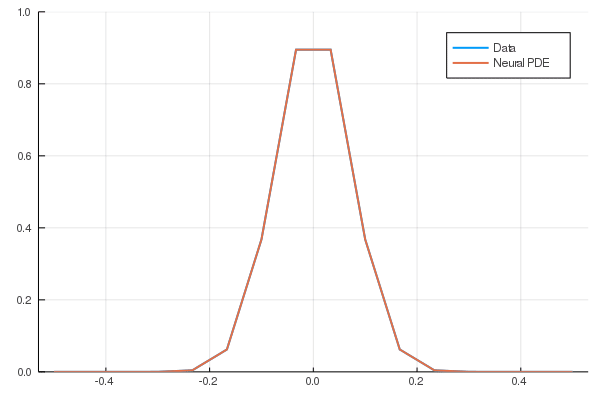

In [122]:
u_NN = zeros(N, Nt_data)
u_NN[:, 1] .= u₀
for n in 2:Nt_data
    sol = diffusion_npde(u_NN[:, n-1])
    u_NN[:, n] .= sol.u[1]
end

anim = @animate for n=1:Nt_data-1
    plot(x, uₙ[:, n],    linewidth=2, ylim=(0, 1), label="Data", show=false)
    plot!(x, u_NN[:, n], linewidth=2, ylim=(0, 1), label="Neural PDE", show=false)
end
gif(anim, "diffusion_neural_pde_gaussian.gif", fps=15)

Let's see how well it fits

$$ u_0(x) = 1 - cos(2\pi x) $$

┌ Info: Saved animation to 
│   fn = /home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_cosine.gif
└ @ Plots /home/alir/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_cosine.gif")
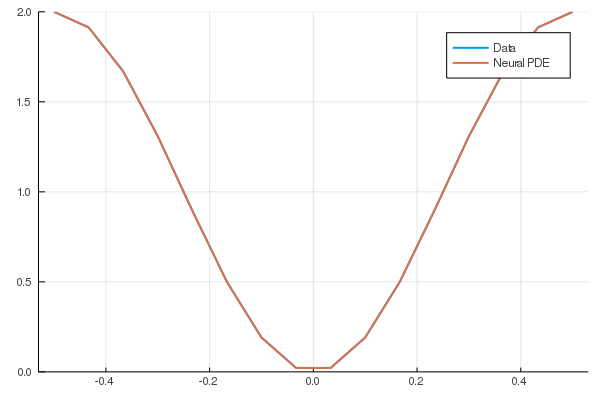

In [118]:
u₀_cos = @. 1 - cos(2π * x)

prob = ODEProblem(diffusion!, u₀_cos, tspan, params)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

u_NN = zeros(N, Nt_data)
u_NN[:, 1] .= u₀_cos
for n in 2:Nt_data
    sol = diffusion_npde(u_NN[:, n-1])
    u_NN[:, n] .= sol.u[1]
end

anim = @animate for n=1:Nt_data-1
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 2), label="Data", show=false)
    plot!(x, u_NN[:, n], linewidth=2, ylim=(0, 2), label="Neural PDE", show=false)
end
gif(anim, "diffusion_neural_pde_cosine.gif", fps=15)